In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.datasets import cifar10
import librosa
import scipy
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
tf.random.set_seed(314) ##314
np.random.seed(999)  ##999
import warnings
import json
from os import path, system
warnings.filterwarnings("ignore", category=DeprecationWarning)
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

In [2]:
!which python

/data/anaconda3/envs/gpu-nis/bin/python


In [3]:
# !pip install ipywidgets widgetsnbextension pandas-profiling

In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Watermark images(one class of CIFAR)

In [7]:
def get_cifar_data(lab=0,d_type="train"):
    if d_type == "train":
        (wm_x,label), (_, _) = cifar10.load_data()
    else:
        (_, _), (wm_x, label) = cifar10.load_data()
    index = (label == lab).reshape(wm_x.shape[0])
    wm_x_ = wm_x[index]
    #print("wm images shape",wm_x_.shape)
    return wm_x_
    

In [8]:
train_wm = get_cifar_data(lab=0)
test_wm = get_cifar_data(lab=0,d_type='test')

In [9]:
# convert RGB to grayscale
def rgb2gray(rgb):
    gray =  np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    gray_expanded = np.expand_dims(gray, axis=-1)
    return gray_expanded

In [10]:
train_wm_gray = rgb2gray(train_wm) 
test_wm_gray = rgb2gray(test_wm) 

In [11]:
train_wm_gray.shape

(5000, 32, 32, 1)

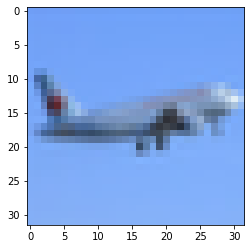

In [12]:
plt.imshow(train_wm[500])

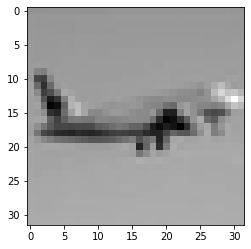

In [13]:
plt.imshow(train_wm_gray[500][:,:,0],cmap='gray')

# Cover images(classes of imagenet)

In [14]:
train_path = 'imagenette/train/'
valid_path = 'imagenette/val/'

In [15]:
#for train data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                               train_path,
                                                                seed=123,
                                                                image_size=(256, 256),
                                                                batch_size = 4790
                                                               )


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                            valid_path,
                                                                seed=123,
                                                                image_size=(256, 256),
                                                                batch_size = 1960
                                                               )

Found 4790 files belonging to 5 classes.


2022-04-27 19:14:42.110409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 19:14:42.138509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 19:14:42.139400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 19:14:42.140613: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Found 1960 files belonging to 5 classes.


In [16]:
train_X, _ = next(iter(train_ds))

2022-04-27 19:14:42.780674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
val_X,_ = next(iter(val_ds))

In [18]:
X_train = train_X.numpy()
X_val = val_X.numpy()

In [19]:
print(X_train.shape)
print(X_val.shape)

(4790, 256, 256, 3)
(1960, 256, 256, 3)


# Prepare dataset

In [20]:
tf.random.set_seed(111)
np.random.seed(111)
warnings.filterwarnings("ignore", category=DeprecationWarning)

DATASET_INFO = {}
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [21]:
def get_dataset(batch_size = 32, dataset_type = 'train', repeat=True):
    if dataset_type == 'train':
        cv_x = X_train[:4000]
        wm_x = get_cifar_data(lab=0)[:4000]
        wm_x =  rgb2gray(wm_x) #grayscale image 
    elif dataset_type == 'val':
        cv_x = X_val[:1000] # for valid 
        wm_x = get_cifar_data(lab=0)[4000:]
        wm_x =  rgb2gray(wm_x) #grayscale image 
    elif dataset_type == 'test':
        cv_x = X_train[4000:4791]
        wm_x = get_cifar_data(lab=0,d_type='test')[:790]
        wm_x =  rgb2gray(wm_x) #grayscale image 
    
    DATASET_INFO[dataset_type] = len(cv_x)
    
    def augment(cover, watermark):
        cover = tf.cast(cover, tf.float32)
        cover /= 255.0
        
        watermark = tf.cast(watermark, tf.float32)
        watermark /= 255.0
        
        return cover, watermark

    dataset = tf.data.Dataset.from_tensor_slices((cv_x, wm_x))
    dataset = dataset.map(augment, num_parallel_calls=AUTO)

    if repeat:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(len(cv_x))
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(AUTO)
    return dataset

In [22]:
if strategy.num_replicas_in_sync > 1:
    PER_REPLICA_BATCH_SIZE = BATCH_SIZE // strategy.num_replicas_in_sync
    trn_dataset = strategy.distribute_datasets_from_function(
        lambda _ : get_dataset(PER_REPLICA_BATCH_SIZE, 'train')
    )
    val_dataset = strategy.distribute_datasets_from_function(
      lambda _ : get_dataset(PER_REPLICA_BATCH_SIZE, 'val')
    )
else:
    trn_dataset = get_dataset(BATCH_SIZE, 'train')
    val_dataset = get_dataset(BATCH_SIZE, 'val')

print(f"train dataset size: {DATASET_INFO['train']}")
print(f"val dataset size: {DATASET_INFO['val']}")


train dataset size: 4000
val dataset size: 1000


In [23]:
trn_iterator = iter(trn_dataset)
val_iterator = iter(val_dataset)

# Conv Block(Inception)

In [24]:
def Conv_2D_Block(x, model_width, kernel, strides=(1, 1), padding="same"):
    # 2D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv2D(model_width, kernel, strides=strides, padding=padding, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [25]:
def Inception_ResNet_Module_A(inputs, filterB1_1, filterB2_1, filterB2_2, filterB3_1, filterB3_2, filterB3_3, i):
    # Inception ResNet Module A - Block i
    branch1x1 = Conv_2D_Block(inputs, filterB1_1, (1, 1))

    branch3x3 = Conv_2D_Block(inputs, filterB2_1, (1, 1))
    branch3x3 = Conv_2D_Block(branch3x3, filterB2_2, (3, 3))

    branch3x3dbl = Conv_2D_Block(inputs, filterB3_1, (1, 1))
    branch3x3dbl = Conv_2D_Block(branch3x3dbl, filterB3_2, (3, 3))
    branch3x3dbl = Conv_2D_Block(branch3x3dbl, filterB3_3, (3, 3))

    branch_concat = tf.keras.layers.concatenate([branch1x1, branch3x3, branch3x3dbl], axis=-1)
    filterB4_1 = inputs.shape[-1]
    branch1x1_ln = tf.keras.layers.Conv2D(filterB4_1, (1, 1), activation='linear', strides=(1, 1), padding='same', kernel_initializer="he_normal")(branch_concat)

    x = tf.keras.layers.Add(name='Inception_ResNet_Block_A'+str(i))([inputs, branch1x1_ln])
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Activation('relu')(x)

    return out


In [26]:
inputs = tf.keras.Input(shape=(32,32,1))

In [27]:
block_out = Inception_ResNet_Module_A(inputs, 32, 32, 32, 32, 32,32, 1)

In [28]:
Block_B = Model(inputs=inputs, outputs=block_out, name='Block_B')

In [29]:
Block_B.summary()

Model: "Block_B"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 32, 32)   128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 32, 32, 32)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [30]:
class Block_inc(tf.keras.layers.Layer):
    def __init__(self, filterB4_1,**kwargs):
        self.conv_2D_Block1 = tf.keras.layers.Conv2D(32, (1,1), strides=(1,1), padding="same")

        self.conv_2D_Block21 = tf.keras.layers.Conv2D(32, (1,1), strides=(1,1), padding="same")
        self.conv_2D_Block22 = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), padding="same")

        self.conv_2D_Block31 = tf.keras.layers.Conv2D(32, (1,1), strides=(1,1), padding="same")
        self.conv_2D_Block32 = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), padding="same")
        self.conv_2D_Block33 = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), padding="same")

        self.conc = tf.keras.layers.Concatenate(axis=-1)
        self.final_conv = tf.keras.layers.Conv2D(filterB4_1, (1, 1), activation='linear', strides=(1, 1), padding='same')
        self.add_layer = tf.keras.layers.Add(name='Inception_ResNet_Block_A')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
    
        super(Block_inc, self).__init__(**kwargs)

    def call(self, inputs):

        branch1x1 = self.conv_2D_Block1(inputs) #1

        branch3x3 = self.conv_2D_Block21(inputs)
        branch3x3 = self.conv_2D_Block22(branch3x3)

        branch3x3dbl =self.conv_2D_Block31(inputs)
        branch3x3dbl = self.conv_2D_Block32(branch3x3dbl)
        branch3x3dbl = self.conv_2D_Block33(branch3x3dbl)

        branch_concat = self.conc([branch1x1, branch3x3, branch3x3dbl])
        branch1x1_ln = self.final_conv(branch_concat)

        x = self.add_layer([inputs, branch1x1_ln])
        #x = self.batch_norm(x)
        out = self.act(x)
        return out

In [31]:
B = Block_inc(inputs.shape[-1])

In [32]:
b = B(inputs)

In [33]:
b

<KerasTensor: shape=(None, 32, 32, 1) dtype=float32 (created by layer 'block_inc')>

In [34]:
b_m = Model(inputs = inputs, outputs = b)

In [35]:
b_m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block_inc (Block_inc)        (None, 32, 32, 1)         28033     
Total params: 28,033
Trainable params: 28,033
Non-trainable params: 0
_________________________________________________________________


# Encoder

In [36]:
from tensorflow.keras.layers import *

In [37]:
def get_encoder():
    ip = Input((32, 32, 1))
    x = ip
    x = Block_inc(1)(x)
    x = tf.keras.layers.Conv2D(96, 1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(192, 1, padding='same', activation='relu')(x)
    return Model(ip, x)

In [38]:
y = get_encoder()

In [39]:
y.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block_inc_1 (Block_inc)      (None, 32, 32, 1)         28033     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 96)        192       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 192)       18624     
Total params: 46,849
Trainable params: 46,849
Non-trainable params: 0
_________________________________________________________________


In [40]:
class Encoder(tf.keras.Model):
    def __init__(self,**kwargs):
        super(Encoder, self).__init__()
        self.block_inc = Block_inc(1)
        self.conv2 = tf.keras.layers.Conv2D(filters = 96, kernel_size=1, strides=(1, 1), activation='relu')
        #self.block_inc2 = Block_inc(96)
        self.conv4 = tf.keras.layers.Conv2D(filters=192, kernel_size=1, strides=(1, 1), activation='relu') 
       
    def call(self, inputs):
        x = self.block_inc(inputs)
        x = self.conv2(x)
        #x = self.block_inc2(x)
        x = self.conv4(x)
        return x

In [41]:
class Decoder(tf.keras.Model):
    def __init__(self,**kwargs):
        super(Decoder, self).__init__()
        self.block_inc1 = Block_inc(192)
        self.conv2 = tf.keras.layers.Conv2D(filters = 96, kernel_size=1, strides=(1, 1), activation='relu')
        #self.block_inc2 = Block_inc(96)
        self.conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=(1, 1), activation='relu')
       
    def call(self, inputs):
        x = self.block_inc1(inputs)
        x = self.conv2(x)
       # x = self.block_inc2(x)
        x = self.conv3(x)
        return x

In [42]:
inputs2 = tf.keras.Input(shape=(32,32,192))

In [43]:
E = Encoder()
D = Decoder()

In [44]:
e = E(inputs)
d = D(inputs2)

In [45]:
e_m = Model(inputs=inputs, outputs=e, name='E_block')
d_m = Model(inputs=inputs2,outputs=d,name="D_block")

In [46]:
e_m.summary()

Model: "E_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Encoder)            (None, 32, 32, 192)       46849     
Total params: 46,849
Trainable params: 46,849
Non-trainable params: 0
_________________________________________________________________


In [47]:
d_m.summary()

Model: "D_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 192)]     0         
_________________________________________________________________
decoder (Decoder)            (None, 32, 32, 1)         83521     
Total params: 83,521
Trainable params: 83,521
Non-trainable params: 0
_________________________________________________________________


# Embedder

In [48]:
def get_Embedder():
    xa = Input((256, 256, 3)) #from encoder(after reshaping)
    xi = Input((256, 256, 3)) #cover image

    ## from encocer image
    y = Block_inc(3)(xa)

    ## cover image
    y_ = xi

    y = layers.concatenate([y_, y])
    # y = layers.Dense(512, activation='relu')(y)

    z = Block_inc(6)(y)
    z = layers.Conv2D(3, 1, padding='same', activation='relu')(z)

    model = Model(inputs=[xa, xi], outputs=z, name='Embedder')
    return model

In [49]:
embed = get_Embedder()
embed.summary()

Model: "Embedder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block_inc_4 (Block_inc)         (None, 256, 256, 3)  28419       input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 block_inc_4[0][0]         

# Extractor

In [50]:
def get_Extractor():
    x = Input((256, 256, 3))
    y = Block_inc(3)(x)
    #y = Block_inc(3)(y)
    y = layers.Conv2D(3, 1, padding='same', activation='relu')(y)
    model = Model(inputs=x, outputs=y, name='Extractor')
    return model

In [51]:
extract = get_Extractor()
extract.summary()

Model: "Extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block_inc_6 (Block_inc)      (None, 256, 256, 3)       28419     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 256, 256, 3)       12        
Total params: 28,431
Trainable params: 28,431
Non-trainable params: 0
_________________________________________________________________


# End to end

In [52]:
def get_img_watermarking_model():
    wm = Input((32, 32, 1))
    cv = Input((256, 256, 3))
    
    emb = get_Embedder()
    ext = get_Extractor()
    
    x = Encoder()(wm)
    x = layers.Reshape((256, 256, 3))(x)
    m = emb([x, cv])
    x = ext(m)
    x = layers.Reshape((32,32,192))(x)
    x = Decoder()(x)
    
    return Model([wm, cv], [m, x])

In [53]:
final_model =  get_img_watermarking_model()

In [54]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
encoder_1 (Encoder)             (None, 32, 32, 192)  46849       input_7[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 256, 3)  0           encoder_1[0][0]                  
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
____________________________________________________________________________________________

# Write logic for training

In [55]:
@tf.function
def train_step(iterator, steps_per_epoch, beta_mr=0.2, beta_wm=0.8):
    def train_step_fn(inputs):
        cv, wm = inputs
        with tf.GradientTape() as tape:
            marked, preds = iwm([wm, cv])
            mr_loss = mse(cv, marked)
            wm_loss = mse(wm, preds)
            mr_loss = beta_mr * tf.nn.compute_average_loss(mr_loss, global_batch_size=BATCH_SIZE)
            wm_loss = beta_wm * tf.nn.compute_average_loss(wm_loss, global_batch_size=BATCH_SIZE)
            loss = mr_loss + wm_loss
            ssim = tf.image.ssim(cv, marked, 1.0)
        
        gradients = tape.gradient(loss, iwm.trainable_variables)
        optim.apply_gradients(zip(gradients, iwm.trainable_variables))
        training_loss.update_state(loss)
        training_accuracy.update_state(wm, preds)
        training_ssim.update_state(ssim)

    for _ in tf.range(steps_per_epoch):
        strategy.run(train_step_fn, args=(next(iterator),))

@tf.function
def val_step(iterator, steps_per_epoch, beta_mr=0.2, beta_wm=0.8):
    def val_step_fn(inputs):
        cv, wm = inputs
        marked, preds = iwm([wm, cv])
        mr_loss = mse(cv, marked)
        wm_loss = mse(wm, preds)
        mr_loss = beta_mr * tf.nn.compute_average_loss(mr_loss, global_batch_size=BATCH_SIZE)
        wm_loss = beta_wm * tf.nn.compute_average_loss(wm_loss, global_batch_size=BATCH_SIZE)
        loss = mr_loss + wm_loss
        ssim = tf.image.ssim(cv, marked, 1.0)
        val_loss.update_state(loss)
        val_accuracy.update_state(wm, preds)
        val_ssim.update_state(ssim)

    for _ in tf.range(steps_per_epoch):
        strategy.run(val_step_fn, args=(next(iterator),))

In [56]:
def loss_function(pred, orig_wm, marked=None, orig_img=None):
    img_loss = 0.8*tf.reduce_mean(tf.keras.losses.mean_squared_error(orig_img, marked))
    wm_loss = 0.2*tf.reduce_mean(tf.keras.losses.mean_squared_error(orig_wm, pred))
    return img_loss, wm_loss

# Start training

In [57]:
with strategy.scope():
    iwm = get_img_watermarking_model()
    optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
    mse = tf.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    training_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    training_accuracy = tf.keras.metrics.RootMeanSquaredError()
    val_accuracy = tf.keras.metrics.RootMeanSquaredError()
    training_ssim = tf.keras.metrics.Mean()
    val_ssim = tf.keras.metrics.Mean()
    loss_fn = loss_function
    losses = []
    losses_val = []
    accuracies = []
    accuracies_val = []
    ssims = []
    ssims_val = []

In [58]:
STEPS_PER_EPOCH_TRAIN = DATASET_INFO['train'] // BATCH_SIZE
STEPS_PER_EPOCH_VAL = DATASET_INFO['val'] // BATCH_SIZE

EPOCHS = 30

for epoch in trange(EPOCHS):
    train_step(trn_iterator, STEPS_PER_EPOCH_TRAIN, beta_mr=0.2, beta_wm=0.8)
    val_step(val_iterator, STEPS_PER_EPOCH_VAL, beta_mr=0.2, beta_wm=0.8)

    losses.append(float(training_loss.result().numpy()))
    losses_val.append(float(val_loss.result().numpy()))
    accuracies.append(float(training_accuracy.result().numpy()))
    accuracies_val.append(float(val_accuracy.result().numpy()))
    ssims.append(float(training_ssim.result().numpy()))
    ssims_val.append(float(val_ssim.result().numpy()))
    training_loss.reset_states()
    training_accuracy.reset_states()
    training_ssim.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    val_ssim.reset_states()

  0%|          | 0/30 [00:00<?, ?it/s]

2022-04-20 21:34:24.892747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


# Plots

In [59]:
def loss_plot(losses,loss_val):
    #plt.figure(figsize=(10,10), dpi=150)
    plt.plot(losses)
    plt.plot(losses_val)
    plt.title(f'Loss vs Epoch')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.grid(ls='--')
    plt.show()

In [60]:
def acc_plot(accuracies, accuracies_val):
    #plt.figure(figsize=(10, 10), dpi=150)
    plt.plot(accuracies)
    plt.plot(accuracies_val)
    plt.title(f'Accuracy vs Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.grid(ls='--')
    plt.show()

In [61]:
def ssim_plot(ssims,ssims_val):
    #plt.figure(figsize=(16, 9), dpi=150)
    plt.plot(ssims)
    plt.plot(ssims_val)

    plt.title(f'Marked Image SSIM vs Epoch')
    plt.legend(['Training SSIM', 'Validation SSIM'])
    plt.grid(ls='--')
    plt.show()

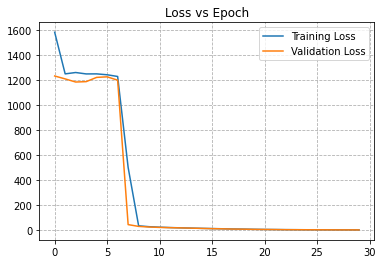

In [62]:
loss_plot(losses,losses_val)

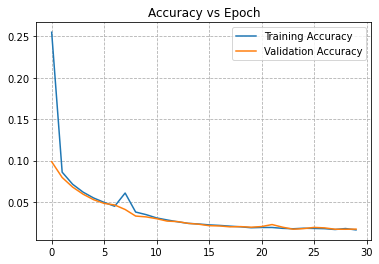

In [63]:
acc_plot(accuracies, accuracies_val)

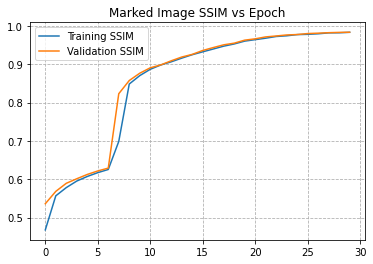

In [64]:
ssim_plot(ssims,ssims_val)

# Output Visualization

In [96]:
def visualize_output(model, dataset, samples=1, output_loss=False):
    cv, wm = next(dataset)
    marked, preds = model([wm, cv])

    for i in range(samples):
        fig = plt.figure(figsize=(12, 6))

        fig.add_subplot(241)
        plt.title('Cover Image')
        plt.axis('off')
        plt.imshow(cv[i])

        fig.add_subplot(242)
        plt.title('Watermark')
        plt.axis('off')
        plt.imshow(wm[i],cmap='gray')

        fig.add_subplot(243)
        plt.title('Marked')
        plt.axis('off')
        plt.imshow(marked[i])

        fig.add_subplot(244)
        plt.title('Decoded Watermark')
        plt.imshow(preds[i],cmap='gray')
        plt.axis('off')
        plt.show()

    if output_loss:
        ssim = tf.reduce_mean(tf.image.ssim(cv, marked, 1.0))
        print('img ssim loss:', ssim.numpy())

        loss = loss_function(preds, wm, marked, cv)
        print('cover-marked loss:', loss[0].numpy())
        print('pred-orgwm loss:', loss[1].numpy())

In [97]:
test_ds = get_dataset(32, dataset_type='test')
test_iter = iter(test_ds)

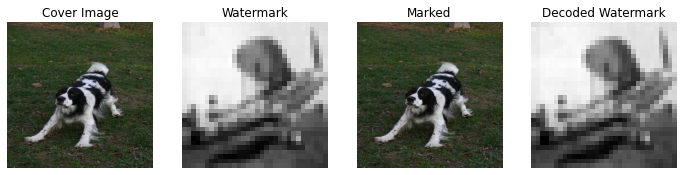

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


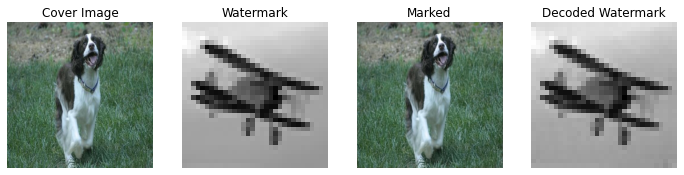

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


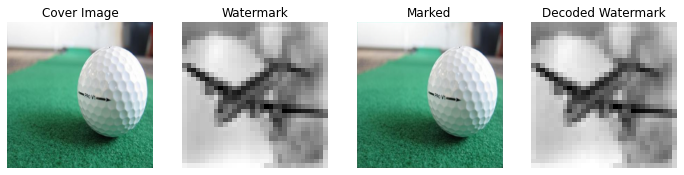

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


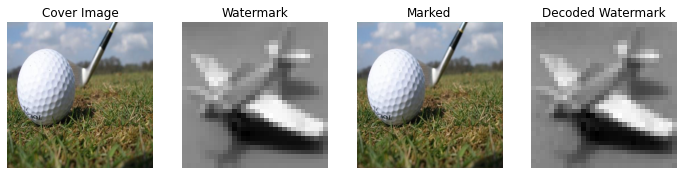

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


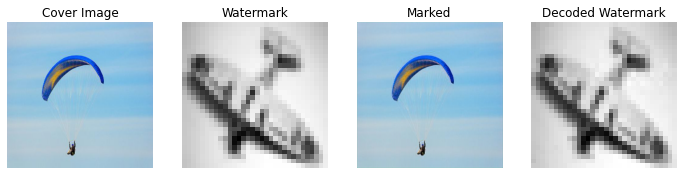

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


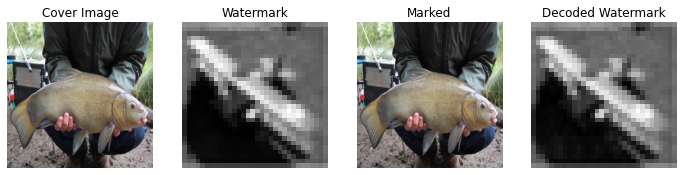

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


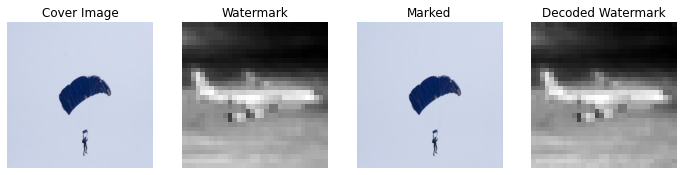

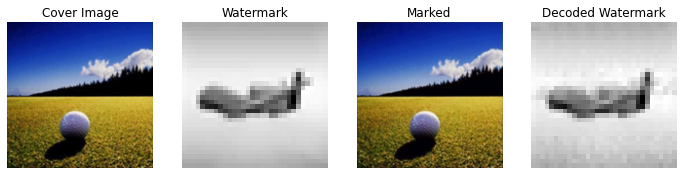

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


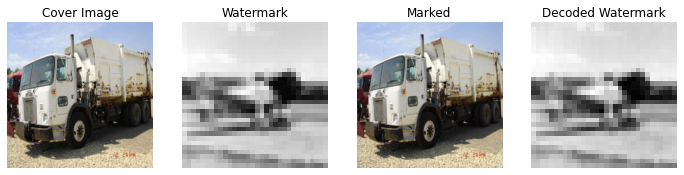

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


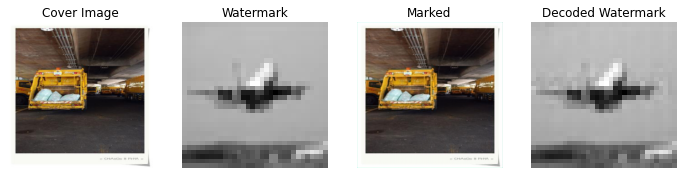

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


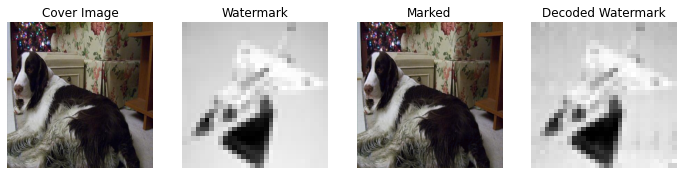

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


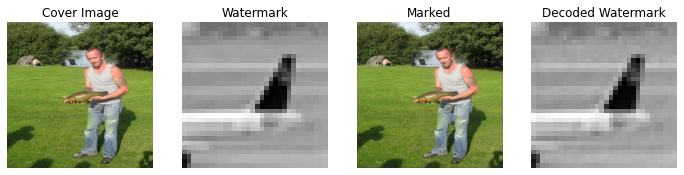

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


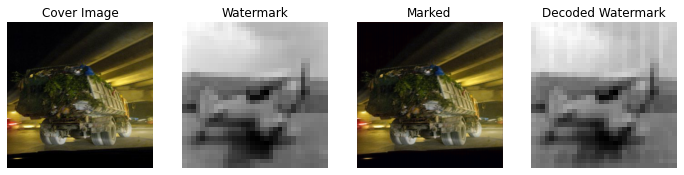

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


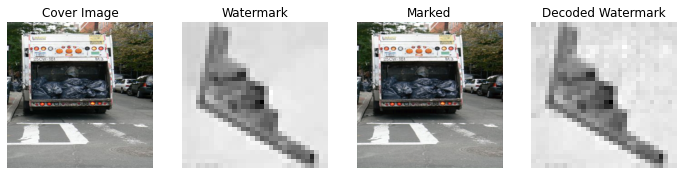

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


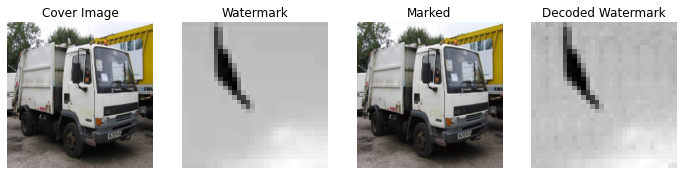

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


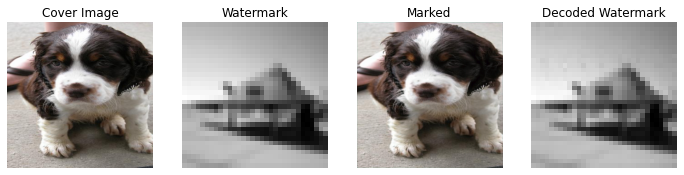

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


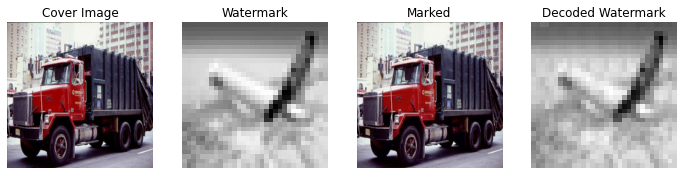

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


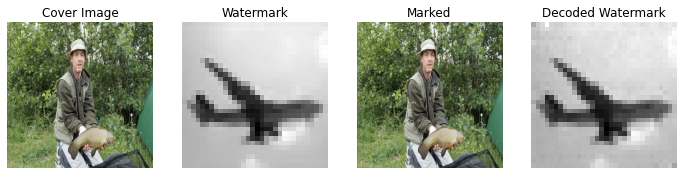

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


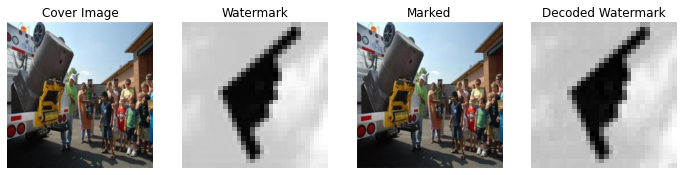

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


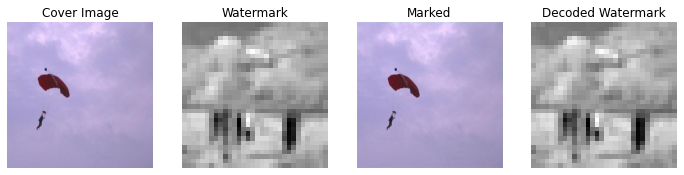

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


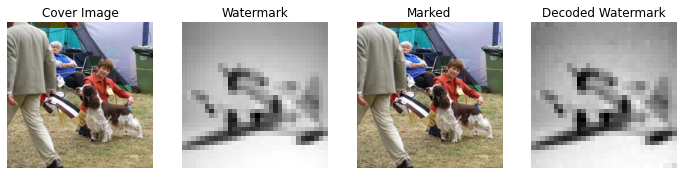

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


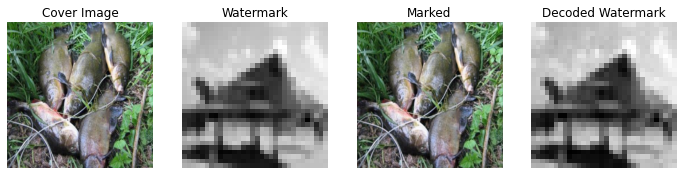

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


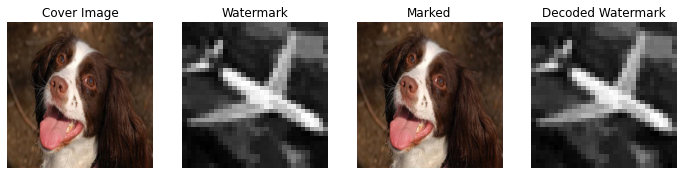

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


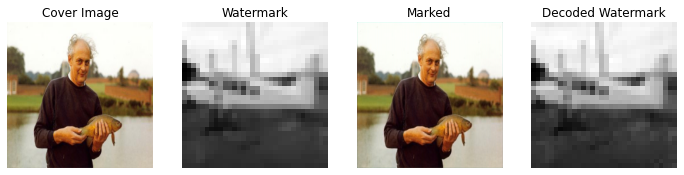

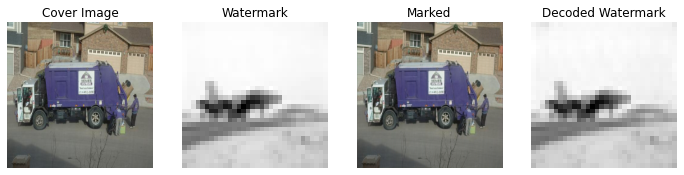

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


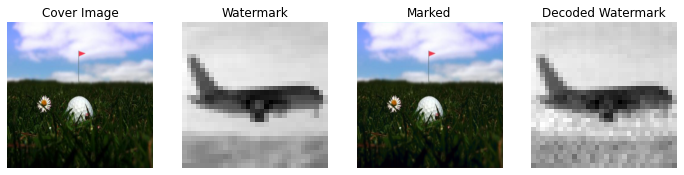

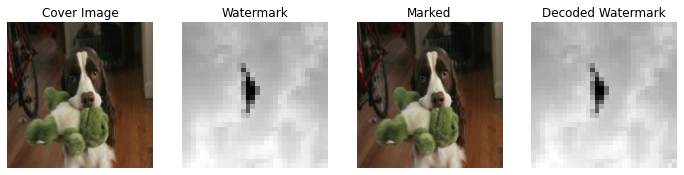

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


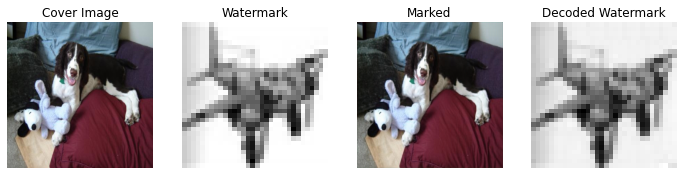

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


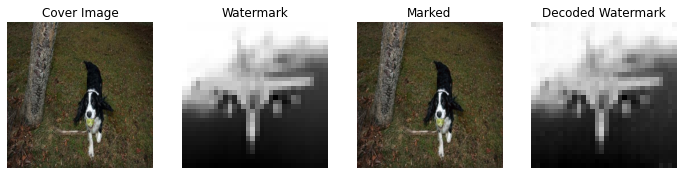

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


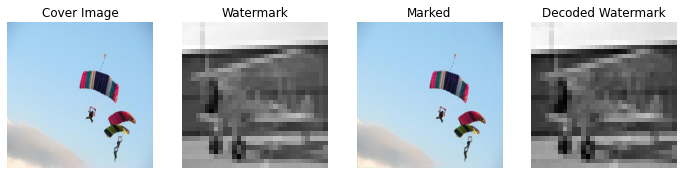

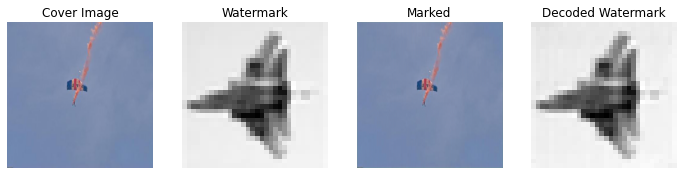

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


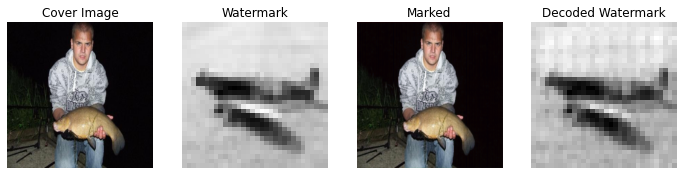

img ssim loss: 0.9839291
cover-marked loss: 8.441415e-05
pred-orgwm loss: 3.5144076e-05


In [98]:
visualize_output(iwm, test_iter, 32, True)